# Does variability change under anthropogenic forcing?

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scipy.stats import ks_2samp
from scipy.stats import norm

## Load Data

### Load pre-processed timeseries

Model output.

In [3]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

In [4]:
cesm1_ensresponse_olr = cesm1_ensresponse_ds['FLUT']
cesm1_pic_olr = cesm1_pic_ds['FLUT']

Are the variabilities in OLR different from unforced simulations after 25, 50 years?

What factors make they different if so?

What about different months of the year?

#### Define functions

In [5]:
def pi_tseries_to_ens(pic_var_dict,tlength,nmembers,verbose=True):
    '''
    This function takes a long control run and returns N (nmembers) non-overlapping members of length tlength (years).
    If the long control run does not have enough time for this, the function returns as many members as fit in.
    '''
    
    month_increment = tlength*12 # length of the timeseries

    pic_final_dict = {}
    for _var in pic_var_dict: # iterate over keys, which are the variables
        if verbose:
            print(_var)

        pic_tseries_dict = {}

        for mem_n in range(nmembers):
            # Define index start and endpoints
            start_index = mem_n*month_increment
            end_index = start_index + month_increment

            if end_index > len(pic_var_dict[_var].time):
                print('Cannot fit %d non-overlapping ensemble members of %d years in the available data. Returning %d members.' % (nmembers,tlength,mem_n))
                break
            sub_tseries = pic_var_dict[_var].isel(time=slice(start_index,end_index))

            # print(sub_tseries.time) # test code demonstrates non-overlapping t-series

            # create a fake timeseries so that we can combine these fake ensemble members
            # timeseries must be between print(pd.Timestamp.min) and print(pd.Timestamp.max) 1677 and 2262 roughly. I am just starting mine at 1700 so they are obviously PI
            new_times = pd.date_range('1700/01/01',freq='1M',periods=month_increment,closed=None) 
            new_times_da = xr.DataArray(new_times, [('time', new_times)]) # turn into an xarray object
            sub_tseries_timefixed = sub_tseries.assign_coords({'time':new_times_da})

            sub_tseries_timefixed['ens'] = mem_n # add ensemble coordinate for easy combining

            pic_tseries_dict[str(mem_n)] = sub_tseries_timefixed

        pic_all_tseries = xr.concat(list(pic_tseries_dict.values()),dim='ens')

        pic_final_dict[_var] = pic_all_tseries
    
    return pic_final_dict

In [6]:
def simple_detrend(tseries,dim):
    '''
    Pass a timeseries and the dimension to detrend along.
    '''
    
    polyfit = tseries.polyfit(dim=dim,deg=1) # take a linear fit
    slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
    
    linearized_tseries = slopes.sel(degree=1)*tseries[dim] + slopes.sel(degree=0) # construct the linear fit
    detrended_tseries  = tseries - linearized_tseries # remove the linear fit to detrend the timeseries
    
    return detrended_tseries

In [7]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate

In [8]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data,testing=False):
    ''' Standardize the data. '''
    
    # if data.std()==0: # edge case that the standard deviation is zero
    if np.isclose(data.std(),0,atol=1e-5): # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    if testing:
        print(data)
        print(data_std)
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [9]:
# 25 years go into 1800 years 72 times
pi_tseries_25yrs = pi_tseries_to_ens(cesm1_pic_olr.to_dataset(),tlength=25,nmembers=72,verbose=False)['FLUT']
pi_tseries_50yrs = pi_tseries_to_ens(cesm1_pic_olr.to_dataset(),tlength=50,nmembers=36,verbose=False)['FLUT']

#### Do analysis on annual averages to start.

Slopes of unforced subset sof the PI-Control simulation.

In [10]:
pi_tseries_25yrs_annavg = pi_tseries_25yrs.groupby('time.year').mean('time')
pi_tseries_50yrs_annavg = pi_tseries_50yrs.groupby('time.year').mean('time')

In [11]:
# I LOVE XARRAY FUNCTIONALITY
pi_25yr_ann_trends = pi_tseries_25yrs_annavg.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
pi_50yr_ann_trends = pi_tseries_50yrs_annavg.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)

In [12]:
bins = np.arange(-0.15,0.151,0.025)

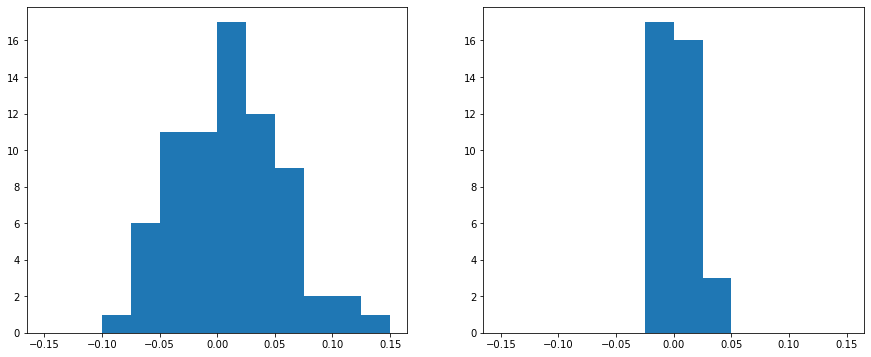

In [13]:
fig,axs = plt.subplots(1,2,figsize=(15,6))

axs[0].hist(pi_25yr_ann_trends.values,bins=bins)

_=axs[1].hist(pi_50yr_ann_trends.values,bins=bins)

Wow, the trends clearly go to zero after ~50 years.

Calculate the lag-1 autocorrelation and standard deviation of the internal variability.

In [14]:
pi_25yr_ann_lag1 = pi_tseries_25yrs_annavg.groupby('ens').map(calc_lag1_autocorr)
pi_50yr_ann_lag1 = pi_tseries_50yrs_annavg.groupby('ens').map(calc_lag1_autocorr)

pi_25yr_ann_stddev = pi_tseries_25yrs_annavg.std(dim='ens')
pi_50yr_ann_stddev = pi_tseries_50yrs_annavg.std(dim='ens')

(array([ 0.,  0.,  1.,  4.,  4., 13., 10., 13.,  5.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

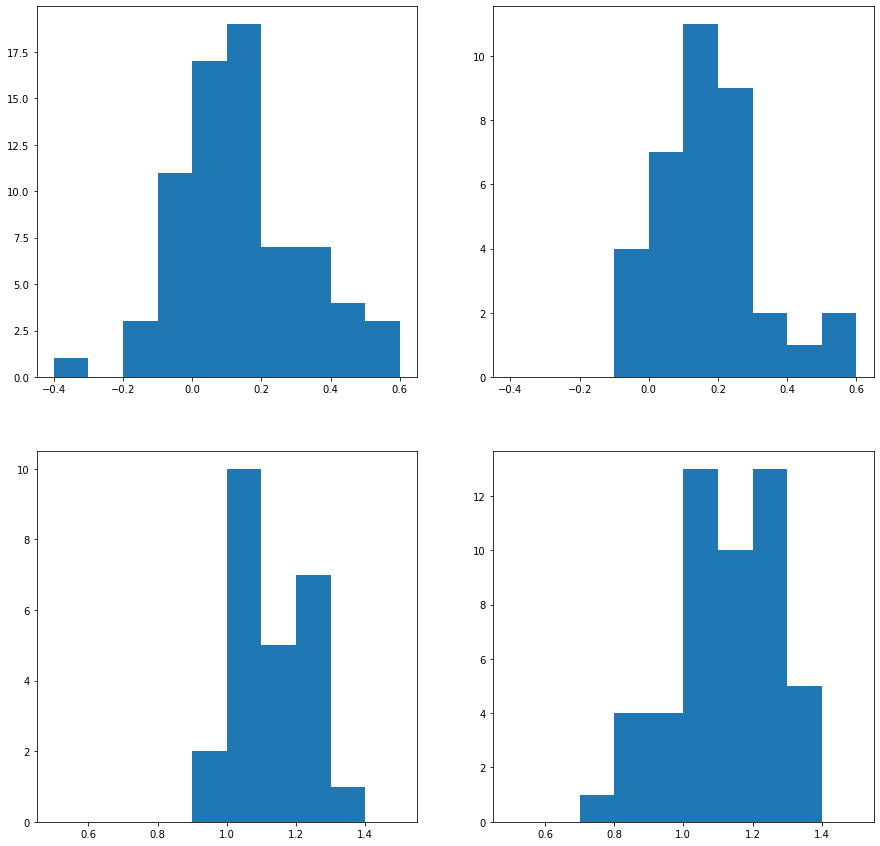

In [15]:
fig,axs = plt.subplots(2,2,figsize=(15,15))
axs = axs.flat

# Lag-1 autocorrelations
axs[0].hist(pi_25yr_ann_lag1.values,bins=np.arange(-0.4,0.7,0.1))
axs[1].hist(pi_50yr_ann_lag1.values,bins=np.arange(-0.4,0.7,0.1))

# Standard deviations
axs[2].hist(pi_25yr_ann_stddev.values,bins=np.arange(0.5,1.6,0.1))
axs[3].hist(pi_50yr_ann_stddev.values,bins=np.arange(0.5,1.6,0.1))

Interesting, there isn't much different between the noise with 25 year vs 50 years. In both cases, we need more time to reach the true values.

__Slopes of the forced ensemble after the forced response is removed.__

In [16]:
forced_ens_annavg  = cesm1_ensresponse_olr.groupby('time.year').mean('time')
forced_resp_annavg = forced_ens_annavg.mean(dim='ens')

In [17]:
deforced_ens_annavg = forced_ens_annavg - forced_resp_annavg # xarray knows how to broadcast

In [18]:
deforced_ens_annavg_2001_2025 = deforced_ens_annavg.sel(year=slice(2001,2025))
deforced_ens_annavg_2001_2050 = deforced_ens_annavg.sel(year=slice(2001,2050))

deforced_2001_2025_ann_trends = deforced_ens_annavg_2001_2025.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
deforced_2001_2050_ann_trends = deforced_ens_annavg_2001_2050.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)

In [19]:
deforced_ens_annavg_2026_2050 = deforced_ens_annavg.sel(year=slice(2026,2050))
deforced_ens_annavg_2051_2075 = deforced_ens_annavg.sel(year=slice(2051,2075))

deforced_2026_2050_ann_trends = deforced_ens_annavg_2026_2050.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
deforced_2051_2075_ann_trends = deforced_ens_annavg_2051_2075.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)

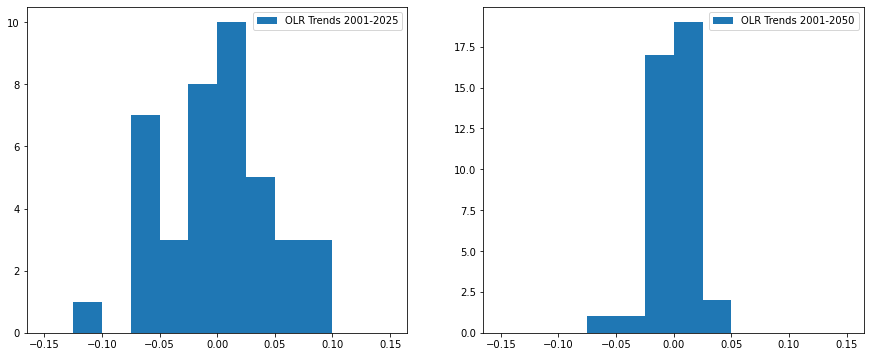

In [20]:
fig,axs = plt.subplots(1,2,figsize=(15,6))

axs[0].hist(deforced_2001_2025_ann_trends.values,bins=bins,label='OLR Trends 2001-2025')
axs[0].legend()

_=axs[1].hist(deforced_2001_2050_ann_trends.values,bins=bins,label='OLR Trends 2001-2050')
axs[1].legend()

Calculate the lag-1 autocorrelation and standard deviation of the internal variability.

In [21]:
ens_2001_2025_ann_lag1 = deforced_ens_annavg_2001_2025.groupby('ens').map(calc_lag1_autocorr)
ens_2001_2050_ann_lag1 = deforced_ens_annavg_2001_2050.groupby('ens').map(calc_lag1_autocorr)

ens_2001_2025_ann_stddev = deforced_ens_annavg_2001_2025.std(dim='ens')
ens_2001_2050_ann_stddev = deforced_ens_annavg_2001_2050.std(dim='ens')

In [22]:
ens_2026_2050_ann_lag1 = deforced_ens_annavg_2026_2050.groupby('ens').map(calc_lag1_autocorr)
ens_2051_2075_ann_lag1 = deforced_ens_annavg_2051_2075.groupby('ens').map(calc_lag1_autocorr)

ens_2026_2050_ann_stddev = deforced_ens_annavg_2026_2050.std(dim='ens')
ens_2051_2075_ann_stddev = deforced_ens_annavg_2051_2075.std(dim='ens')

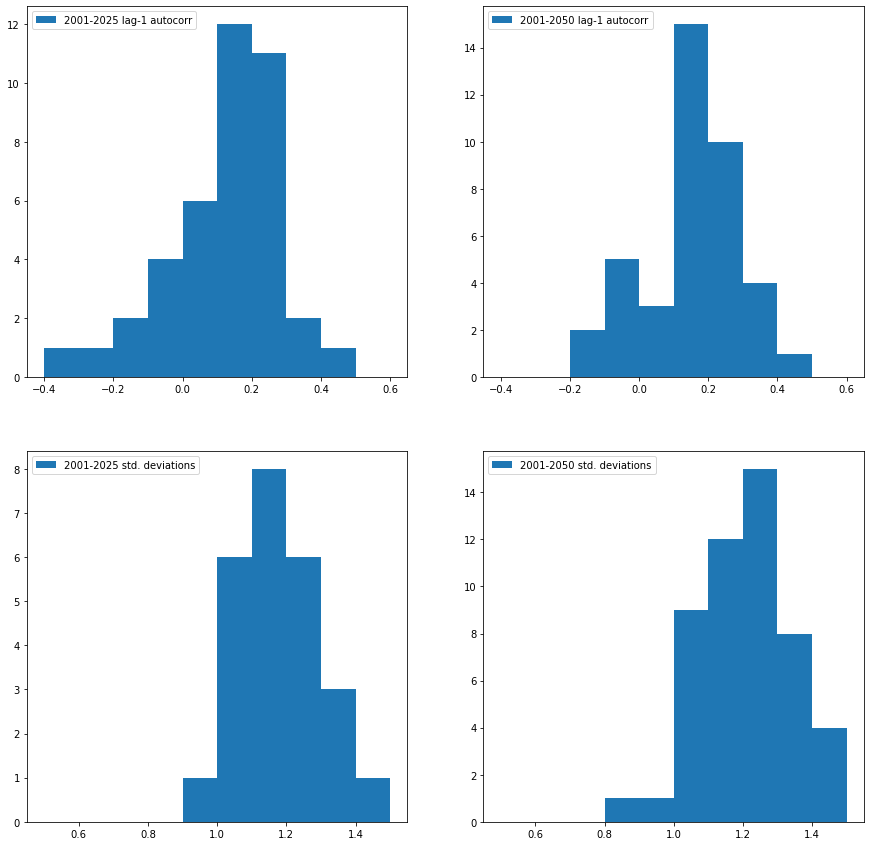

In [23]:
fig,axs = plt.subplots(2,2,figsize=(15,15))
axs = axs.flat

# Lag-1 autocorrelations
axs[0].hist(ens_2001_2025_ann_lag1.values,bins=np.arange(-0.4,0.7,0.1),label='2001-2025 lag-1 autocorr')
axs[1].hist(ens_2001_2050_ann_lag1.values,bins=np.arange(-0.4,0.7,0.1),label='2001-2050 lag-1 autocorr')

# Standard deviations
axs[2].hist(ens_2001_2025_ann_stddev.values,bins=np.arange(0.5,1.6,0.1),label='2001-2025 std. deviations')
axs[3].hist(ens_2001_2050_ann_stddev.values,bins=np.arange(0.5,1.6,0.1),label='2001-2050 std. deviations')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

These distributions look very similar, so variability doesn't appear to be changing much between 25 and 50 years.

In [24]:
#perform Kolmogorov-Smirnov test
out = ks_2samp(pi_25yr_ann_trends, deforced_2001_2025_ann_trends)

if out[1] < 0.05:
    print('reject the null hypothesis')
    
else:
    print('Cannot distinguish between the distributions of trends')
    
print(out)

Cannot distinguish between the distributions of trends
KstestResult(statistic=0.15555555555555556, pvalue=0.5107237686197157)


In [25]:
#perform Kolmogorov-Smirnov test
out = ks_2samp(pi_50yr_ann_trends, deforced_2001_2050_ann_trends)

if out[1] < 0.05:
    print('reject the null hypothesis')
    
else:
    print('Cannot distinguish between the distributions of trends')
    
print(out)

Cannot distinguish between the distributions of trends
KstestResult(statistic=0.16944444444444445, pvalue=0.5803688509160849)


Applying a KS test confirms this, the distribution of unforced slopes is not statistically different in the forced or unforced ensembles for 25 or 50 years.

What about properties of the variability?

In [26]:
comp_2001_2025_lag1 = ks_2samp(pi_25yr_ann_lag1,ens_2001_2025_ann_lag1)
comp_2001_2050_lag1 = ks_2samp(pi_50yr_ann_lag1,ens_2001_2050_ann_lag1)

comp_2001_2025_stddev = ks_2samp(pi_25yr_ann_stddev,ens_2001_2025_ann_stddev)
comp_2001_2050_stddev = ks_2samp(pi_50yr_ann_stddev,ens_2001_2050_ann_stddev)

if comp_2001_2025_lag1[1] < 0.05:
    print('Lag-1 autocorrelation at 25 years is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')
    
if comp_2001_2050_lag1[1] < 0.05:
    print('Lag-1 autocorrelation at 50 years is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')
    
if comp_2001_2025_stddev[1] < 0.05:
    print('Standard deviation at 25 years is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')
    
if comp_2001_2050_stddev[1] < 0.05:
    print('Standard deviation at 50 years is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')

Standard deviation at 50 years is different from natural variability


Ok, we got a hit! The standard deviation at 50 years is different from natural variability, let's plot to visualize how!

In [27]:
comp_2001_2050_stddev

KstestResult(statistic=0.3, pvalue=0.02170784069014051)

Text(0, 0.5, 'Number')

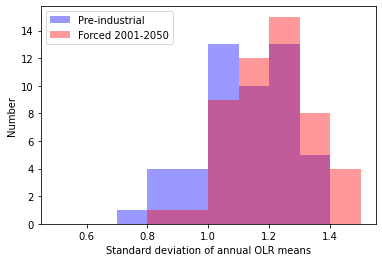

In [28]:
plt.hist(pi_50yr_ann_stddev.values,bins=np.arange(0.5,1.6,0.1),
        color='blue',alpha=0.4,label='Pre-industrial')
plt.hist(ens_2001_2050_ann_stddev.values,bins=np.arange(0.5,1.6,0.1),
        color='red',alpha=0.4,label='Forced 2001-2050')
plt.legend()

plt.xlabel('Standard deviation of annual OLR means')
plt.ylabel('Number')

Ok, there is more variability in the forced climate than in the unforced climate __on annual scale__! Cool!

Test the other two 25 year periods.

__2026-2050 and 2051-2075:__

In [29]:
comp_2026_2050_lag1 = ks_2samp(pi_25yr_ann_lag1,ens_2026_2050_ann_lag1)
comp_2051_2075_lag1 = ks_2samp(pi_25yr_ann_lag1,ens_2051_2075_ann_lag1)

comp_2026_2050_stddev = ks_2samp(pi_25yr_ann_stddev,ens_2026_2050_ann_stddev)
comp_2051_2075_stddev = ks_2samp(pi_50yr_ann_stddev,ens_2051_2075_ann_stddev)

if comp_2026_2050_lag1[1] < 0.05:
    print('Lag-1 autocorrelation at 2026-2050 is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')
    
if comp_2051_2075_lag1[1] < 0.05:
    print('Lag-1 autocorrelation at 2051-2075 is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')
    
if comp_2026_2050_stddev[1] < 0.05:
    print('Standard deviation at 2026-2050 is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')
    
if comp_2051_2075_stddev[1] < 0.05:
    print('Standard deviation at 2051-2075 is different from natural variability')
    
# else:
#     print('Cannot distinguish between the distributions of trends')

Standard deviation at 2051-2075 is different from natural variability


Again, the standard deviation of OLR is different, but only for the latest 25-year period.

In [30]:
comp_2051_2075_stddev

KstestResult(statistic=0.4, pvalue=0.008195049552130573)

Text(0, 0.5, 'Number')

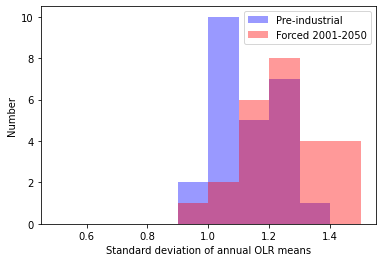

In [31]:
plt.hist(pi_25yr_ann_stddev.values,bins=np.arange(0.5,1.6,0.1),
        color='blue',alpha=0.4,label='Pre-industrial')
plt.hist(ens_2051_2075_ann_stddev.values,bins=np.arange(0.5,1.6,0.1),
        color='red',alpha=0.4,label='Forced 2001-2050')
plt.legend()

plt.xlabel('Standard deviation of annual OLR means')
plt.ylabel('Number')

This shows even more separation but similarly indicating an increase in the annual OLR variability in the second half of the century.

#### Repeat for months of the year.

It is important to have a hypothesis going in here. I hypothesize that months where sea ice cover goes from high to low will see an increase in variability, because different ensemble members will lose sea ice at different times.

However, I could also make the opposite argument, that OLR variability will decrease as open water increases do to the increase in heat capacity of the open ocean (its ability to moderate surface temperature changes driven by synoptic events).

Perhaps there is a trade-off between these competing effects or they manifest in different ways?

__Hypothesis: Variability will be different in October, November, April, and May.__

In [32]:
# need a wrapper function because you can't groupby multiple dimensions
def gettrends_wrapper(dataarray,dim):
    
    dataarray[dim] = dataarray['time.year']

    return dataarray.groupby('ens').map(xr.DataArray.polyfit,dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)

In [33]:
def calclag1_wrapper(dataarray):
    
    return dataarray.groupby('ens').map(calc_lag1_autocorr)

Additional processing of the CESM1-LE ensemble members.

In [34]:
cesm1_forcedresponse = cesm1_ensresponse_olr.mean(dim='ens')#cesm1_ensresponse_olr -  
cesm1_deforced = cesm1_ensresponse_olr - cesm1_forcedresponse

In [35]:
cesm1_deforced_2001_2025 = cesm1_deforced.sel(time=slice(None,'2025-12-31'))
cesm1_deforced_2001_2050 = cesm1_deforced.sel(time=slice(None,'2050-12-31'))

cesm1_deforced_2026_2050 = cesm1_deforced.sel(time=slice('2026-01-01','2050-12-31'))
cesm1_deforced_2051_2075 = cesm1_deforced.sel(time=slice('2051-01-01','2075-12-31'))

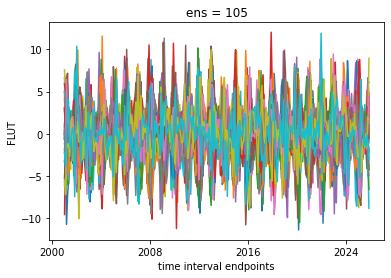

In [36]:
for i in cesm1_deforced_2001_2025:
    i.plot()

Why do they look like this? We've removed the seasonal variations? Answer: The seasonal variability is still present, and that is what we are looking at!

Calculate trends for the PI-Control and deforced ensembles.

In [37]:
monthly_pi_trends_25yr = pi_tseries_25yrs.groupby('time.month').map(gettrends_wrapper,dim='time')
monthly_pi_trends_50yr = pi_tseries_50yrs.groupby('time.month').map(gettrends_wrapper,dim='time')

monthly_ens_trends_2001_2025 = cesm1_deforced_2001_2025.groupby('time.month').map(gettrends_wrapper,dim='time')
monthly_ens_trends_2001_2050 = cesm1_deforced_2001_2050.groupby('time.month').map(gettrends_wrapper,dim='time')

monthly_ens_trends_2026_2050 = cesm1_deforced_2026_2050.groupby('time.month').map(gettrends_wrapper,dim='time')
monthly_ens_trends_2051_2075 = cesm1_deforced_2051_2075.groupby('time.month').map(gettrends_wrapper,dim='time')

Calculate the variability characteristics for the PI-Control and deforced ensembles.

In [38]:
# Standard deviation
pi_25yr_mon_stddev = pi_tseries_25yrs.groupby('time.month').map(xr.DataArray.std,dim='time')
pi_50yr_mon_stddev = pi_tseries_50yrs.groupby('time.month').map(xr.DataArray.std,dim='time')

ens_2001_2025_mon_stddev = cesm1_deforced_2001_2025.groupby('time.month').map(xr.DataArray.std,dim='time')
ens_2001_2050_mon_stddev = cesm1_deforced_2001_2050.groupby('time.month').map(xr.DataArray.std,dim='time')

ens_2026_2050_mon_stddev = cesm1_deforced_2026_2050.groupby('time.month').map(xr.DataArray.std,dim='time')
ens_2051_2075_mon_stddev = cesm1_deforced_2051_2075.groupby('time.month').map(xr.DataArray.std,dim='time')

In [39]:
# Lag-1 autocorrelation
pi_25yr_mon_lag1 = pi_tseries_25yrs.groupby('time.month').map(calclag1_wrapper)
pi_50yr_mon_lag1 = pi_tseries_50yrs.groupby('time.month').map(calclag1_wrapper)

ens_2001_2025_mon_lag1 = cesm1_deforced_2001_2025.groupby('time.month').map(calclag1_wrapper)
ens_2001_2050_mon_lag1 = cesm1_deforced_2001_2050.groupby('time.month').map(calclag1_wrapper)

ens_2026_2050_mon_lag1 = cesm1_deforced_2026_2050.groupby('time.month').map(calclag1_wrapper)
ens_2051_2075_mon_lag1 = cesm1_deforced_2051_2075.groupby('time.month').map(calclag1_wrapper)

Now, figure out if these values are statistically different from each other at 95% confidence using a KS test.

In [40]:
def KS_test_diff(data,CI=0.95):
    '''
    Perform a KS test to assess if probability distributions are different.
    '''
    data1 = data['ENS'].dropna(dim='ens')
    data2 = data['PIC'].dropna(dim='ens')
    
    ks_out = ks_2samp(data1,data2)
    
    if ks_out[1] < 1 - CI:
        return xr.DataArray(True)
    else:
        return xr.DataArray(False)

Merge into a common dataset.

In [41]:
# Rename so that they can be merged.
monthly_pi_trends_25yr.name = 'PIC'
monthly_ens_trends_2001_2025.name = 'ENS'
monthly_ens_trends_2026_2050.name = 'ENS'
monthly_ens_trends_2051_2075.name = 'ENS'

monthly_pi_trends_50yr.name = 'PIC'
monthly_ens_trends_2001_2050.name = 'ENS'

pi_25yr_mon_stddev.name = 'PIC'
ens_2001_2025_mon_stddev.name = 'ENS'
ens_2026_2050_mon_stddev.name = 'ENS'
ens_2051_2075_mon_stddev.name = 'ENS'

pi_50yr_mon_stddev.name = 'PIC'
ens_2001_2050_mon_stddev.name = 'ENS'

pi_25yr_mon_lag1.name = 'PIC'
ens_2001_2025_mon_lag1.name = 'ENS'
ens_2026_2050_mon_lag1.name = 'ENS'
ens_2051_2075_mon_lag1.name = 'ENS'

pi_50yr_mon_lag1.name = 'PIC'
ens_2001_2050_mon_lag1.name = 'ENS'

In [42]:
all_2001_2025_mon_trends = xr.merge([monthly_pi_trends_25yr,monthly_ens_trends_2001_2025])
all_2001_2050_mon_trends = xr.merge([monthly_pi_trends_50yr,monthly_ens_trends_2001_2050])

all_2001_2025_mon_stddev = xr.merge([pi_25yr_mon_stddev,ens_2001_2025_mon_stddev])
all_2001_2050_mon_stddev = xr.merge([pi_50yr_mon_stddev,ens_2001_2050_mon_stddev])

all_2001_2025_mon_lag1 = xr.merge([pi_25yr_mon_lag1,ens_2001_2025_mon_lag1])
all_2001_2050_mon_lag1 = xr.merge([pi_50yr_mon_lag1,ens_2001_2050_mon_lag1])

all_2026_2050_mon_trends = xr.merge([monthly_pi_trends_25yr,monthly_ens_trends_2026_2050])
all_2051_2075_mon_trends = xr.merge([monthly_pi_trends_50yr,monthly_ens_trends_2051_2075])

all_2026_2050_mon_stddev = xr.merge([pi_25yr_mon_stddev,ens_2026_2050_mon_stddev])
all_2051_2075_mon_stddev = xr.merge([pi_50yr_mon_stddev,ens_2051_2075_mon_stddev])

all_2026_2050_mon_lag1 = xr.merge([pi_25yr_mon_lag1,ens_2026_2050_mon_lag1])
all_2051_2075_mon_lag1 = xr.merge([pi_50yr_mon_lag1,ens_2051_2075_mon_lag1])

Use the KS test to see if the distributions are different.

In [43]:
trend_change_mon_2001_2025 = all_2001_2025_mon_trends.groupby('month').map(KS_test_diff)
trend_change_mon_2001_2050 = all_2001_2050_mon_trends.groupby('month').map(KS_test_diff)

trend_change_mon_2026_2050 = all_2026_2050_mon_trends.groupby('month').map(KS_test_diff)
trend_change_mon_2051_2075 = all_2051_2075_mon_trends.groupby('month').map(KS_test_diff)

In [44]:
stddev_change_mon_2001_2025 = all_2001_2025_mon_stddev.groupby('month').map(KS_test_diff)
stddev_change_mon_2001_2050 = all_2001_2050_mon_stddev.groupby('month').map(KS_test_diff)

stddev_change_mon_2026_2050 = all_2026_2050_mon_stddev.groupby('month').map(KS_test_diff)
stddev_change_mon_2051_2075 = all_2051_2075_mon_stddev.groupby('month').map(KS_test_diff)

lag1_change_mon_2001_2025 = all_2001_2025_mon_lag1.groupby('month').map(KS_test_diff)
lag1_change_mon_2001_2050 = all_2001_2050_mon_lag1.groupby('month').map(KS_test_diff)

lag1_change_mon_2026_2050 = all_2026_2050_mon_lag1.groupby('month').map(KS_test_diff)
lag1_change_mon_2051_2075 = all_2051_2075_mon_lag1.groupby('month').map(KS_test_diff)

In [45]:
print('Are unforced trends changing monthly?')

print('2001-2025: ',trend_change_mon_2001_2025.values)
print('2001-2050: ',trend_change_mon_2001_2050.values)

print('2026-2050: ',trend_change_mon_2026_2050.values)
print('2051-2075: ',trend_change_mon_2051_2075.values)

Are unforced trends changing monthly?
2001-2025:  [False False False False False False False False False False False False]
2001-2050:  [False False False False False False False False False False False False]
2026-2050:  [False False False False False False False False False False False False]
2051-2075:  [ True False False False  True False False  True False False  True False]


Not until the second half of the century.

__plot this.__

In [46]:
print('Is variability changing monthly?')

print('2001-2025: ',stddev_change_mon_2001_2025.values)
print('2001-2050: ',stddev_change_mon_2001_2050.values)

print('2026-2050: ',stddev_change_mon_2026_2050.values)
print('2051-2075: ',stddev_change_mon_2051_2075.values)

Is variability changing monthly?
2001-2025:  [False False False False False False False False  True False False False]
2001-2050:  [False  True False False False False False False  True  True False False]
2026-2050:  [False False  True False False False False False  True  True False False]
2051-2075:  [False  True  True  True False False False  True  True  True  True False]


Yes, in September for sure and later in February and October. The fall with the sea ice change!!

Lot's of changes in the second half of the century! Especially in the fall but now the spring appears to be active.

Let's visualize how the standard deviation is changing.

Text(0.5, 0.95, 'Standard Deviation: PI-Control (25yrs) vs. 2051-2075')

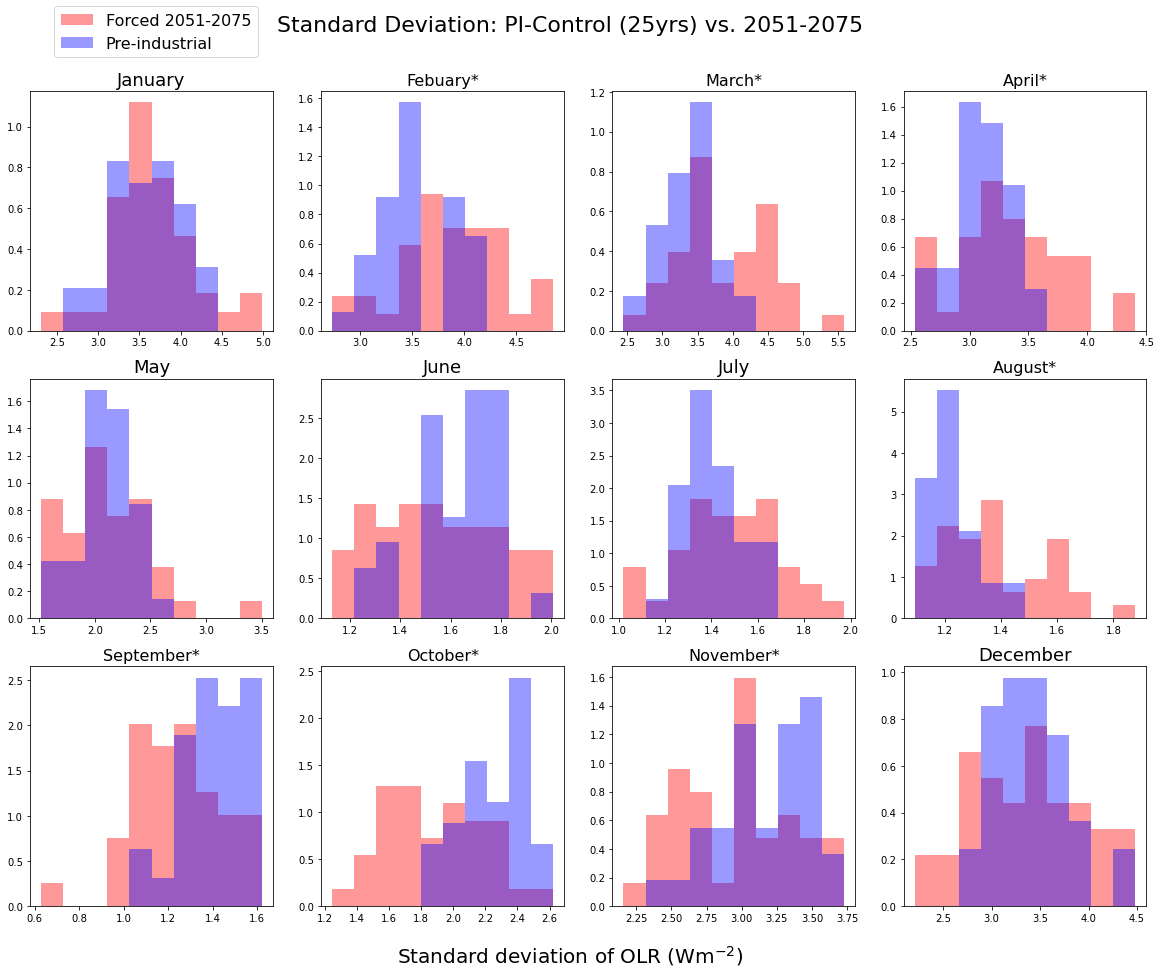

In [47]:
std_fig,std_axs = plt.subplots(3,4,figsize=(20,15))

std_axs = std_axs.flat

month_list = ['January','Febuary','March','April','May','June','July','August','September','October','November','December']

_all_2051_2075_mon_stddev = all_2051_2075_mon_stddev.transpose("month","ens")
_all_PIC = _all_2051_2075_mon_stddev['PIC']
_all_ENS = _all_2051_2075_mon_stddev['ENS']

# iterate over month of the year
for _ax,PIC_vals,ENS_vals,mon_label in zip(std_axs,_all_PIC,_all_ENS,month_list):
    # save the forced bins and pass them to the unforced case
    # _,_bins,out1 = _ax.hist(ENS_vals.values, #bins=np.arange(0.5,1.6,0.1),
    #                      color='red',alpha=0.4,label='Forced 2051-2075',
    #                      density=True,bins=10)
    # _,_,out2 = _ax.hist(PIC_vals.values,bins=_bins,
    #         color='blue',alpha=0.4,label='Pre-industrial',
    #         density=True)#,bins=10)

    bins = np.histogram_bin_edges(ENS_vals.dropna(dim='ens')) # get bins from the numpy hist function
    sns.distplot(ENS_vals.dropna(dim='ens'),norm_hist=True,
                color='red',label='Forced 2051-2075',
                bins=bins,ax=_ax,kde=False,)
                # fit=norm)
    sns.distplot(PIC_vals.dropna(dim='ens'),norm_hist=True,
                color='blue',label='Pre-industrial',
                bins=bins,ax=_ax,kde=False,)
                # fit=norm)
    
    # Check if the distributions are different
    statsig = stddev_change_mon_2051_2075.sel(month=PIC_vals.month).values
    
    _ax.set_xlabel(None)
    if statsig: # indicate significance
        _ax.set_title(mon_label + '*',fontsize=16)
    else:
        _ax.set_title(mon_label,fontsize=18)
        
std_axs[0].legend(fontsize=16,loc=(0.1,1.14))
std_fig.text(0.5,0.08,'Standard deviation of OLR (Wm$^{-2}$)',fontsize=20,ha='center',va='center')
std_fig.suptitle('Standard Deviation: PI-Control (25yrs) vs. 2051-2075',fontsize=22,y=0.95)

# std_fig.legend(out1,out2)

My automation of the histogram bins is messing up in September when the overlap is not very large.

__Let's investigate the changes that we are seeing in the standard deviation by looking at the histograms.__

Text(0, 0.5, 'Number')

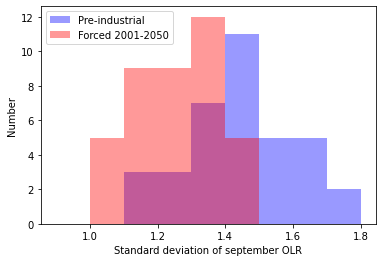

In [48]:
plt.hist(pi_50yr_mon_stddev.sel(month=9).values,bins=np.arange(0.9,1.81,0.1),
        color='blue',alpha=0.4,label='Pre-industrial')
plt.hist(ens_2001_2050_mon_stddev.sel(month=9).values,bins=np.arange(0.9,1.81,0.1),
        color='red',alpha=0.4,label='Forced 2001-2050')
plt.legend()

plt.xlabel('Standard deviation of september OLR')
plt.ylabel('Number')

In the fall, there is less variability in the future climate, perhaps consistent with more open water and a greater thermal inertia moderating synoptic-scale variability.

But in the late winter/early spring we see the opposite effect! Greater variability in the forced climate.

August is an outlier, but we expect some "significant" changes to occur randomly. Is there a mechanism though?

__plot this.__

In [49]:
print('Is variability changing monthly?')

print('2001-2025: ',lag1_change_mon_2001_2025.values)
print('2001-2050: ',lag1_change_mon_2001_2050.values)

print('2026-2050: ',lag1_change_mon_2026_2050.values)
print('2051-2075: ',lag1_change_mon_2051_2075.values)

Is variability changing monthly?
2001-2025:  [False False False False False False False False False False False False]
2001-2050:  [False False  True False False False False False False False False False]
2026-2050:  [False False False False False False False False False  True False False]
2051-2075:  [False False False False False False  True False  True  True False False]


Maybe in March, but I'm not sure if we have a mechanism, so this could be anomalous.

In the second half of the century, the lag-1 does change, I wonder how....

__I hypothesize that the lag-1 autocorrelation will decrease as the freeze-up shifts into October and September is only characterized by open water.__

This does seem to be the case, but the lag-1 autocorrelation is super noisy at 25 years so I think we are best to look just at the standard deviation of the deforced timeseries.

Text(0.5, 0.95, 'OLR Lag-1 autocorrelation: PI-Control (25yrs) vs. 2051-2075')

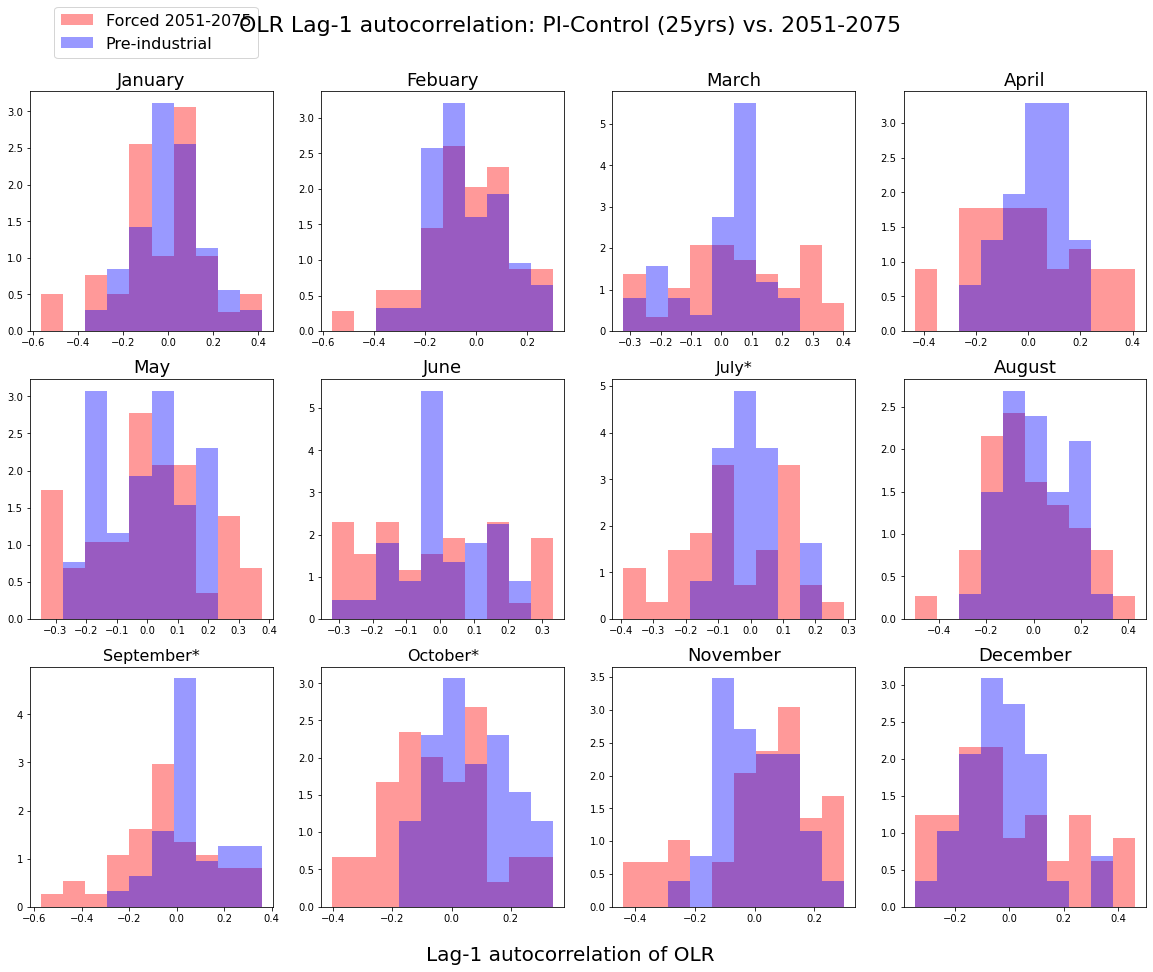

In [50]:
lag1_fig,lag1_axs = plt.subplots(3,4,figsize=(20,15))

lag1_axs = lag1_axs.flat

month_list = ['January','Febuary','March','April','May','June','July','August','September','October','November','December']

_all_2051_2075_mon_lag1 = all_2051_2075_mon_lag1.transpose("month","ens")
_all_PIC = _all_2051_2075_mon_lag1['PIC']
_all_ENS = _all_2051_2075_mon_lag1['ENS']

# iterate over month of the year
for _ax,PIC_vals,ENS_vals,mon_label in zip(lag1_axs,_all_PIC,_all_ENS,month_list):
    # save the forced bins and pass them to the unforced case
    _,_bins,out1 = _ax.hist(ENS_vals.values, #bins=np.arange(0.5,1.6,0.1),
                         color='red',alpha=0.4,label='Forced 2051-2075',
                         density=True,bins=10)
    _,_,out2 = _ax.hist(PIC_vals.values,bins=_bins,
            color='blue',alpha=0.4,label='Pre-industrial',
            density=True)#,bins=10)

    
    # Check if the distributions are different
    statsig = lag1_change_mon_2051_2075.sel(month=PIC_vals.month).values
    
    if statsig: # indicate significance
        _ax.set_title(mon_label + '*',fontsize=16)
    else:
        _ax.set_title(mon_label,fontsize=18)
        
lag1_axs[0].legend(fontsize=16,loc=(0.1,1.14))
lag1_fig.text(0.5,0.08,'Lag-1 autocorrelation of OLR',fontsize=20,ha='center',va='center')
lag1_fig.suptitle('OLR Lag-1 autocorrelation: PI-Control (25yrs) vs. 2051-2075',fontsize=22,y=0.95)

# std_fig.legend(out1,out2)

#### Look at the inter-ensemble variability of OLR as a function of time. Suggested by Jen and slightly different than what I was showing but really good for showing the evolution of OLR variability as the Arctic loses ice cover.

Figure S6 from Swart et al. (2014) in Nature Climate Change.  
https://static-content.springer.com/esm/art%3A10.1038%2Fnclimate2483/MediaObjects/41558_2015_BFnclimate2483_MOESM354_ESM.pdf

Mean emergence of all months and the annual average using the Weatherhead approach (from fig6_OLRemergence).
[32.225, 35.975, 40.425, 41.7  , 37.375, 39.475, 33.95 , 25.175,21.925, 22.6  , 23.55 , 27.325, 20.375]

In [51]:
def convolve_wrapper(a,v,mode='full'):
    
    return xr.DataArray(np.convolve(a,v,mode))

def calc_confidence_interval(data,CI):
    '''
    Calculate a confidence interval on data
    $$ \mu = \bar{x} \pm z_{\alpha/2} \frac{\sigma}{\sqrt{N}} $$
    '''
    
    alpha = 1 - CI
    N = data.shape[0]
    
    t_crit = np.abs(stats.t.ppf(alpha/2,df=N)) # calculate a critical t-statistic
    
    mean = np.mean(data)
    std  = np.std(data)
    
    # Calculate the bounds of the confidence interval
    low  = mean - t_crit*std # / np.sqrt(N-1) # <-- decision about this
    high = mean + t_crit*std # / np.sqrt(N-1)
    
    bounds_da = xr.DataArray(
        data=np.array([low,high]),
        dims=["bound"],
        coords=dict(
            bound=[0,1]
        ),
    )
    
    return bounds_da

def calc_confidence_interval_wrapper(data,CI,dim):
    
    return data.groupby(dim).map(calc_confidence_interval,CI=CI)

In [52]:
pi_tseries_45yrs = pi_tseries_to_ens(cesm1_pic_olr.to_dataset(),tlength=45,nmembers=40,verbose=False)['FLUT']

# calculate standard deviations with a 9-year moving window in an unforced climate
unforced_olr_std = pi_tseries_45yrs.std(dim='ens')
unforced_olr_std_9yr = unforced_olr_std.groupby('time.month').map(convolve_wrapper,v=np.ones(9)/9,mode='valid')

monthly_olr_std_9yr_CI = unforced_olr_std_9yr.groupby('month').map(calc_confidence_interval,CI=0.95)

Text(0.5, 0.08, 'Year')

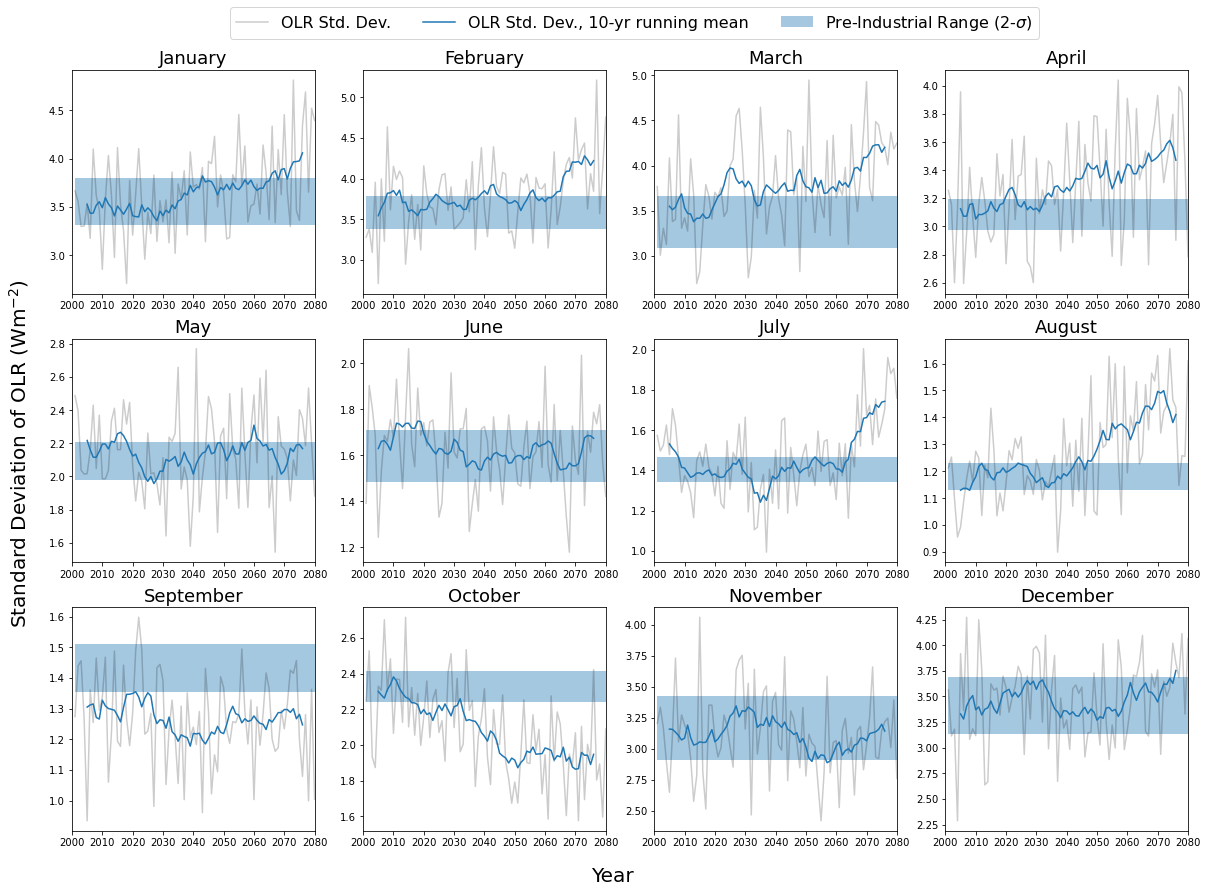

In [54]:
fig,axs = plt.subplots(3,4,figsize=(20,14))
axs = axs.flat

month_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
emerge_years = [32.225, 35.975, 40.425, 41.7, 37.375, 39.475, 33.95, 25.175, 21.925, 22.6, 23.55, 27.325]

for (i,_mon),_ax,_month,_emerge_year,pi_bounds in zip(cesm1_ensresponse_olr.std(dim='ens').groupby('time.month'),axs,month_list,emerge_years,monthly_olr_std_9yr_CI):
    # Calculate a 9-year running mean  (odd so symmetric)
    rolling_avg9 = np.convolve(_mon,np.ones(9)/9,mode='valid')    
    rolling_avg9_padded = np.pad(rolling_avg9,pad_width=4,constant_values=np.nan)    

    # Perform a simple linear regression, is the changing slope significant?
    slope,intercept,rval,pval,stderr = stats.linregress(x=_mon['time.year'],y=_mon)
    
    _ax.plot(_mon['time.year'],_mon,alpha=0.2,color='black',label='OLR Std. Dev.')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
    _ax.plot(_mon['time.year'],rolling_avg9_padded,label='OLR Std. Dev., 10-yr running mean')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
    
    _ax.fill_between(x=_mon['time.year'],y1=pi_bounds[0],y2=pi_bounds[1],alpha=0.4,label='Pre-Industrial Range (2-$\sigma$)')
    
    ymin,ymax = _ax.get_ylim()
    
    # _ax.vlines(x=2001+_emerge_year,ymin=ymin,ymax=ymax,color='black')
    # _ax.legend()

    title = _month
    # if np.abs(slope) > 2*stderr:
    #     title = _month + '*'
    # else:
    #     title = _month
    
    _ax.set_title(title,fontsize=18)
    _ax.set_ylim(ymin,ymax)
    # _ax.set_ylim(1,5)
    _ax.set_xlim(2000,2080)
    
axs[0].legend(fontsize=16,loc=(0.65,1.14),ncol=3)
    
fig.text(x=0.08,y=0.5,s='Standard Deviation of OLR (Wm$^{-2}$)',rotation=90,fontsize=20,va='center')
fig.text(x=0.5,y=0.08,s='Year',rotation=0,fontsize=20,va='center',ha='center')

I should really be plotting the standard deviation on the trends here.

Lots of noise in the variability, but we really care about the variability over several years. So I can calculate a rolling average and use a similar rolling average on the PI-Control simulation to see if the variability has significantly changed before emergence.

This is much noisier than the Swart paper. Also we don't see the same clear increase in variability when the ice cover becomes thin (or when models are losing ice at different rates) and then a big decrease when the Arctic becomes ice-free.

For the late summer months, changing variability occurs too late to matter for emergence. Harder to make a clear call for the winter/spring and fall months with variability change.

In [197]:
unforced_olr_std_annavg = pi_tseries_45yrs.groupby('time.year').mean(dim='time').std(dim='ens')
unforced_olr_std_annavg_9yr = convolve_wrapper(unforced_olr_std_annavg,v=np.ones(9)/9,mode='valid')

olr_std_annavg_9yr_CI = calc_confidence_interval(unforced_olr_std_annavg_9yr,CI=0.95)

Text(0.5, 1.0, 'Annual Average*')

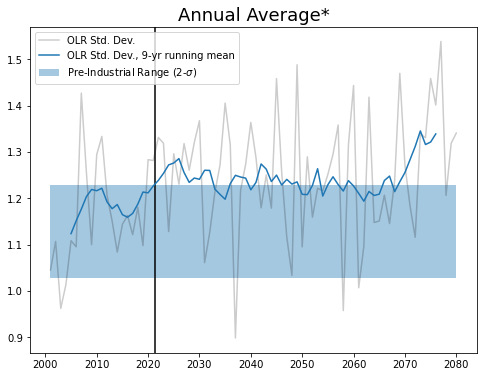

In [202]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

_emerge_year = 20.375

# Calculate a 9-year running mean 
rolling_avg9 = np.convolve(forced_ens_annavg.std(dim='ens'),np.ones(9)/9,mode='valid')    
rolling_avg9_padded = np.pad(rolling_avg9,pad_width=4,constant_values=np.nan)

slope,intercept,rval,pval,stderr = stats.linregress(x=forced_ens_annavg['year'],y=forced_ens_annavg.std(dim='ens'))

ax.plot(forced_ens_annavg['year'],forced_ens_annavg.std(dim='ens'),label='OLR Std. Dev.',alpha=0.2,color='black')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
ax.plot(forced_ens_annavg['year'],rolling_avg9_padded,label='OLR Std. Dev., 9-yr running mean')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))

ax.fill_between(x=forced_ens_annavg['year'],y1=olr_std_annavg_9yr_CI[0],y2=olr_std_annavg_9yr_CI[1],alpha=0.4,label='Pre-Industrial Range (2-$\sigma$)')

ymin,ymax = ax.get_ylim()
ax.vlines(x=2001+_emerge_year,ymin=ymin,ymax=ymax,color='black')

ax.set_ylim(ymin,ymax)
ax.legend()

if np.abs(slope) > 2*stderr:
    title = 'Annual Average' + '*'
else:
    title = 'Annual Average'

ax.set_title(title,fontsize=18)

#### Compute 30-year trends with different start years since trends determine emergence

Compute trends for each month for each year.

For the forced ensemble.

In [391]:
%%time
# 44s is kind of slow! I could parallelize by duration in dask if I wanted to make it faster.

duration = 30
startyears = np.arange(2001,2052)

lens_slopes_monthly_dict = {}

for startyear in startyears:
    
    olr_tsel = cesm1_ensresponse_olr.sel(time=slice(str(startyear),str(startyear+duration-1)))
    
    _monthly_trends = olr_tsel.groupby('time.month').map(gettrends_wrapper,dim='time')
    
    lens_slopes_monthly_dict[startyear] = _monthly_trends
    

# shift the data to an xarray object so future operations do not require iteration
olr_slopes_monthly_30yr_da = xr.DataArray(
    data=np.stack(list(lens_slopes_monthly_dict.values()),axis=1),
    dims=["ens", "startyear","month"],
    coords=dict(
        ens=cesm1_ensresponse_olr['ens'],
        startyear=(startyears),
        month=np.arange(1,13),
    ),
    name = 'FLUT'
)

del lens_slopes_monthly_dict
del _monthly_trends

CPU times: user 26.1 s, sys: 1.79 ms, total: 26.1 s
Wall time: 27.8 s


For the unforced ensemble generated from the PI-Control simulation.

In [304]:
def gettrends_PIC_wrapper(dataarray,dim):
    
    dataarray[dim] = dataarray['time.year']

    return dataarray.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)

Pre-compute unforced 30-year trends (slow)

In [306]:
%%time
# 44s is kind of slow! I could parallelize by duration in dask if I wanted to make it faster.

duration = 20
startyears = np.arange(400,2081,20)

lens_slopes_monthly_dict = {}

for startyear in startyears:
    
    _startyr = str(startyear)
    if len(_startyr)==3:
        _startyr = '0' + _startyr
        
    _endyr = str(startyear+duration-1)
    if len(_endyr)==3:
        _endyr = '0' + _endyr
    
    olr_tsel = cesm1_pic_olr.sel(time=slice(_startyr,_endyr)) # index differently here because the dates are different
    
    _monthly_trends = olr_tsel.groupby('time.month').map(gettrends_PIC_wrapper,dim='time')
    # _monthly_trends = olr_tsel.groupby('time.month').map(xr.DataArray.polyfit,dim='time',deg=1)['polyfit_coefficients'].sel(degree=1)
    
    lens_slopes_monthly_dict[startyear] = _monthly_trends
    
    # break
    

# shift the data to an xarray object so future operations do not require iteration
pic_olr_slopes_monthly_25yr_da = xr.DataArray(
    data=np.stack(list(lens_slopes_monthly_dict.values()),axis=1),
    dims=['month','startyear',],
    coords=dict(
        month=np.arange(1,13),
        startyear=(startyears),
    ),
    name = 'FLUT'
)

del lens_slopes_monthly_dict
del _monthly_trends

CPU times: user 1.96 s, sys: 208 µs, total: 1.96 s
Wall time: 2 s


Annually for the forced ensemble.

In [318]:
%%time 

# durations = np.arange(2,80)

duration = 20
startyears = np.arange(2001,2062)

lens_slopes_annual_dict = {}

for startyear in startyears:
    
    # olr_ann_tsel = forced_ens_annavg.isel(year=slice(None,duration))
    
    olr_ann_tsel = forced_ens_annavg.sel(year=slice(str(startyear),str(startyear+duration-1)))
    
    _annual_trends = olr_ann_tsel.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
        
    lens_slopes_annual_dict[startyear] = _annual_trends
        

# shift the data to an xarray object so future operations do not require iteration
olr_slopes_annual_25yr_da = xr.DataArray(
    data=np.stack(list(lens_slopes_annual_dict.values()),axis=1),
    dims=["ens", "startyear",],
    coords=dict(
        ens=forced_ens_annavg['ens'],
        startyear=(startyears),
        # month=13,
    ),
    name = 'FLUT'
)

del lens_slopes_annual_dict
del _annual_trends

CPU times: user 2.61 s, sys: 4.38 ms, total: 2.61 s
Wall time: 2.65 s


Annually for the unforced ensemble.

In [346]:
%%time 

duration = 20
startyears = np.arange(400,2081,20)

lens_slopes_annual_dict = {}

# pi_tseries_45yrs_annavg = pi_tseries_45yrs.groupby('time.year').mean('time')
cesm1_pic_olr_annavg = cesm1_pic_olr.groupby('time.year').mean('time')


# for duration in durations:
for startyear in startyears:
    
    _startyr = startyear
    # _startyr = str(startyear)
    # if len(_startyr)==3:
    #     _startyr = '0' + _startyr
        
    _endyr = startyear+duration-1
    # _endyr = str(startyear+duration-1)
    # if len(_endyr)==3:
    #     _endyr = '0' + _endyr
    
    olr_ann_tsel = cesm1_pic_olr_annavg.sel(year=slice(_startyr,_endyr)) # index differently here because the dates are different
    
    # olr_ann_tsel = pi_tseries_45yrs_annavg.isel(year=slice(None,duration))
    
    _annual_trends = olr_ann_tsel.polyfit(dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
    # _annual_trends = olr_ann_tsel.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
        
    lens_slopes_annual_dict[startyear] = _annual_trends
    
    # break
    

# shift the data to an xarray object so future operations do not require iteration
pic_olr_slopes_annual_25yr_da = xr.DataArray(
    data=np.array(list(lens_slopes_annual_dict.values())),
    dims=['startyear'],
    coords=dict(
        startyear=startyears,
        # duration=(durations),
        # month=13,
    ),
    name = 'FLUT'
)

del lens_slopes_annual_dict
del _annual_trends

CPU times: user 324 ms, sys: 61 µs, total: 324 ms
Wall time: 324 ms


#### Plot

In [ ]:
pic_olr_slopes_annual_25yr_da

In [ ]:
olr_slopes_annual_25yr_da

In [ ]:
pic_olr_slopes_monthly_25yr_da

In [ ]:
olr_slopes_monthly_25yr_da

Now I can plot the slopes as a function of their start year for the different months and generate a PI confidence interval.

Bootstrap confidence intervals on standard deviations of 30-yr trends from the PI-Control simulation

Pre-compute unforced 30-year trends (slow)

In [413]:
%%time
# 42s is kind of slow! I could parallelize by duration in dask if I wanted to make it faster.

duration = 30
startyears = np.arange(400,2202-duration,1)

# lens_slopes_monthly_dict = {}
trend_array = np.nan * np.ones((12,len(startyears)))

for i,startyear in enumerate(startyears):
    
    _startyr = str(startyear)
    if len(_startyr)==3:
        _startyr = '0' + _startyr
        
    _endyr = str(startyear+duration-1)
    if len(_endyr)==3:
        _endyr = '0' + _endyr
    
    olr_tsel = cesm1_pic_olr.sel(time=slice(_startyr,_endyr)) # index differently here because the dates are different
    
    _monthly_trends = olr_tsel.groupby('time.month').map(gettrends_PIC_wrapper,dim='time')
    # _monthly_trends = olr_tsel.groupby('time.month').map(xr.DataArray.polyfit,dim='time',deg=1)['polyfit_coefficients'].sel(degree=1)
    
    # lens_slopes_monthly_dict[startyear] = _monthly_trends
    trend_array[:,i] = _monthly_trends
    
    # break
    

# shift the data to an xarray object so future operations do not require iteration
pic_olr_slopes_monthly_30yr_da = xr.DataArray(
    data=trend_array,
    # data=np.stack(list(lens_slopes_monthly_dict.values()),axis=1),
    dims=['month','startyear',],
    coords=dict(
        month=np.arange(1,13),
        startyear=(startyears),
    ),
    name = 'FLUT'
)

# del lens_slopes_monthly_dict
del trend_array
del _monthly_trends

CPU times: user 41.6 s, sys: 8.5 ms, total: 41.6 s
Wall time: 42.4 s


In [416]:
# resample the 30-year trends from the PI-Control using bootstrapping to estimate a confidence interval on the standard deviation of 25-year trends
n_bootstraps = 1000

N_ens = 40

_bounds_dict_bstrap = {} # empty dictionary to store objects in

gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
for i in range(n_bootstraps): # bootstrap, calculating percentiles
    # resample along the ensemble dimension (axis 1)
    resample_slopes = gen.choice(pic_olr_slopes_monthly_30yr_da, size=N_ens, replace=True,axis=1)
    
    slope_stddev = resample_slopes.std(axis=1)
    
    _bounds_dict_bstrap[i] = slope_stddev
    
all_bstraps = np.array(list(_bounds_dict_bstrap.values()))

lower_percentile = np.percentile(all_bstraps,2.5,axis=0)
upper_percentile = np.percentile(all_bstraps,97.5,axis=0)


Text(0.5, 0.08, 'Trend Start Year')

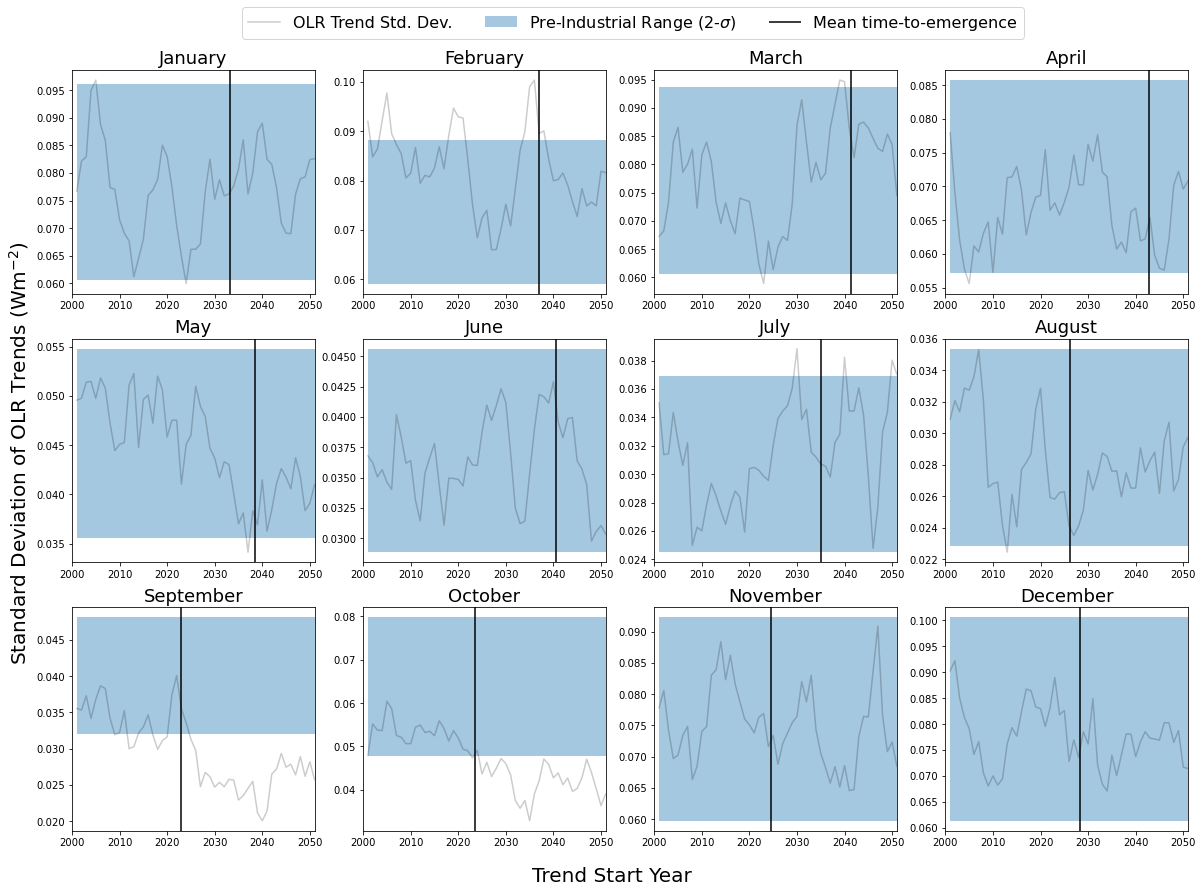

In [434]:
fig,axs = plt.subplots(3,4,figsize=(20,14))
axs = axs.flat

month_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
emerge_years = [32.225, 35.975, 40.425, 41.7, 37.375, 39.475, 33.95, 25.175, 21.925, 22.6, 23.55, 27.325]

# standard deviation on 25 year trends by month and start-year
# olr_slopes_monthly_25yr_std = olr_slopes_monthly_25yr_da.std(dim='ens')
olr_slopes_monthly_30yr_std = olr_slopes_monthly_30yr_da.std(dim='ens')

for (i,_mon),pi_lower,pi_upper,_ax,_month,_emerge_year in zip(olr_slopes_monthly_30yr_std.groupby('month'),lower_percentile,upper_percentile,
                                                              axs,month_list,emerge_years):

    _ax.plot(_mon['startyear'],_mon,alpha=0.2,color='black',label='OLR Trend Std. Dev.')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
    
    _ax.fill_between(x=_mon['startyear'],y1=pi_lower,y2=pi_upper,alpha=0.4,label='Pre-Industrial Range (2-$\sigma$)')
    
    ymin,ymax = _ax.get_ylim()
    
    _ax.vlines(x=2001+_emerge_year,ymin=ymin,ymax=ymax,color='black',label='Mean time-to-emergence')
    
    title = _month
    
    _ax.set_title(title,fontsize=18)
    _ax.set_ylim(ymin,ymax)
    # _ax.set_ylim(1,5)
    _ax.set_xlim(2000,2051)
    
axs[0].legend(fontsize=16,loc=(0.7,1.14),ncol=3)
    
fig.text(x=0.08,y=0.5,s='Standard Deviation of 30-year OLR Trends (Wm$^{-2}$)',rotation=90,fontsize=20,va='center')
fig.text(x=0.5,y=0.08,s='Trend Start Year',rotation=0,fontsize=20,va='center',ha='center')

This plot is still pretty confusing, but it does appear to be telling us that variability is not really changing the range of trends seen in the large ensemble on timescales that are important for detection.

In September and October, the spread of 30-year trends is reduced relative to the PI-Control if we started measuring around 2020, but given that the observational record begins in 2001, we can see that the standard deviation of trends is still within the pre-industrial range, despite decreasing prior to the start of the observational period.

### Old

#### Repeat with trends in the large ensemble

Compute trends for each month for each year.

For the forced ensemble.

In [249]:
%%time
# 44s is kind of slow! I could parallelize by duration in dask if I wanted to make it faster.

durations = np.arange(2,80)

lens_slopes_monthly_dict = {}

for duration in durations:
    
    olr_tsel = cesm1_ensresponse_olr.isel(time=slice(None,12*duration))
    
    _monthly_trends = olr_tsel.groupby('time.month').map(gettrends_wrapper,dim='time')
    
    lens_slopes_monthly_dict[duration] = _monthly_trends
    
    # break
    

# shift the data to an xarray object so future operations do not require iteration
olr_slopes_monthly_da = xr.DataArray(
    data=np.stack(list(lens_slopes_monthly_dict.values()),axis=1),
    dims=["ens", "duration","month"],
    coords=dict(
        ens=cesm1_ensresponse_olr['ens'],
        duration=(durations),
        month=np.arange(1,13),
    ),
    name = 'FLUT'
)

del lens_slopes_monthly_dict
del _monthly_trends

NameError: name 'lens_slopes_dict' is not defined

For the unforced ensemble generated from the PI-Control simulation.

In [254]:
%%time
# 44s is kind of slow! I could parallelize by duration in dask if I wanted to make it faster.

durations = np.arange(2,45)

lens_slopes_monthly_dict = {}

for duration in durations:
    
    olr_tsel = pi_tseries_45yrs.isel(time=slice(None,12*duration))
    
    _monthly_trends = olr_tsel.groupby('time.month').map(gettrends_wrapper,dim='time')
    
    lens_slopes_monthly_dict[duration] = _monthly_trends
    
    # break
    

# shift the data to an xarray object so future operations do not require iteration
pic_olr_slopes_monthly_da = xr.DataArray(
    data=np.stack(list(lens_slopes_monthly_dict.values()),axis=1),
    dims=["ens", "duration","month"],
    coords=dict(
        ens=cesm1_ensresponse_olr['ens'],
        duration=(durations),
        month=np.arange(1,13),
    ),
    name = 'FLUT'
)

del lens_slopes_monthly_dict
del _monthly_trends

CPU times: user 23.2 s, sys: 4.15 ms, total: 23.2 s
Wall time: 23.6 s


Annually for the forced ensemble.

In [245]:
%%time 

durations = np.arange(2,80)

lens_slopes_annual_dict = {}

for duration in durations:
    
    olr_ann_tsel = forced_ens_annavg.isel(year=slice(None,duration))
    
    _annual_trends = olr_ann_tsel.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
    
    # _annual_trends = gettrends_wrapper(olr_ann_tsel,dim='year')
    
    lens_slopes_annual_dict[duration] = _annual_trends
    
    # break
    

# shift the data to an xarray object so future operations do not require iteration
olr_slopes_annual_da = xr.DataArray(
    data=np.stack(list(lens_slopes_annual_dict.values()),axis=1),
    dims=["ens", "duration",],
    coords=dict(
        ens=forced_ens_annavg['ens'],
        duration=(durations),
        # month=13,
    ),
    name = 'FLUT'
)

del lens_slopes_annual_dict
del _annual_trends

CPU times: user 3.42 s, sys: 2.1 ms, total: 3.42 s
Wall time: 3.53 s


Annually for the unforced ensemble.

In [257]:
%%time 

durations = np.arange(2,80)

lens_slopes_annual_dict = {}

pi_tseries_45yrs_annavg = pi_tseries_45yrs.groupby('time.year').mean('time')

for duration in durations:
    
    olr_ann_tsel = pi_tseries_45yrs_annavg.isel(year=slice(None,duration))
    
    _annual_trends = olr_ann_tsel.groupby('ens').map(xr.DataArray.polyfit,dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
        
    lens_slopes_annual_dict[duration] = _annual_trends
    
    # break
    

# shift the data to an xarray object so future operations do not require iteration
pic_olr_slopes_annual_da = xr.DataArray(
    data=np.stack(list(lens_slopes_annual_dict.values()),axis=1),
    dims=["ens", "duration",],
    coords=dict(
        ens=forced_ens_annavg['ens'],
        duration=(durations),
        # month=13,
    ),
    name = 'FLUT'
)

del lens_slopes_annual_dict
del _annual_trends

CPU times: user 3.23 s, sys: 1.35 ms, total: 3.23 s
Wall time: 3.28 s
